## Preliminaries for data processing and analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.cross_validation import cross_val_score,LeaveOneOut,ShuffleSplit
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import scale
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier,OutputCodeClassifier

import scratch as s

Using Theano backend.


## Load, format, and reshape all the Banner Brain and Body Donation Program data

In [2]:
# Load the BBDP excel files, and index by donor ID.  
clinpath = pandas.read_excel('./bbdp/data/Clinicopathological Correlations.xls')
movement = pandas.read_excel('./bbdp/data/Movement Examination.xls')
neuro = pandas.read_excel('./bbdp/data/Neurological Examination.xls')
psych = pandas.read_excel('./bbdp/data/Neuropsychological Examination.xls')
mmse_all = pandas.read_excel('./bbdp/data/MMSE Scores All Sources.xls')
mmse_bbdp = pandas.read_excel('./bbdp/data/MMSE Scores BBDP.xls')
for x in [clinpath,movement,neuro,psych,mmse_all,mmse_bbdp]:
    x.set_index('Donor ID', drop=True, append=False, inplace=True)

In [3]:
# Load the excel file that Joe sent, which contains those subjects for whom UPSIT data is available.  
guide = pandas.read_excel('bbdp/data/D20Mar2015a.xls')
dementia_labels = [row[0] for _,row in guide.iterrows() \
                   if row[2].__class__.__name__ == 'str' and 'Yes with Dementia' in row[2]]
df = pandas.read_excel('bbdp/data/D20Mar2015a.xls',sheetname='Data')

# Create a data frame with this smell data.  
smell = df[['donor_id','shri_case_num','stint','deathage','smell_reduced_or_absent']]#+['smell_%d' % q for q in range(1,41)]]
smell.insert(3,'dementia',[np.any([row[col_label]==2 for col_label in dementia_labels]) \
                           for row_label,row in df.iterrows()])
smell.insert(3,'test_age',df['deathage'] - df['stint'])

# Load the smell test key from the excel file that Brittany sent.  
smell_test_key = pandas.read_excel('bbdp/data/GerkinSmithUPSITautopsy9_10_14.xlsx',sheetname='smellTestKey')
smell_test_key = smell_test_key['Correct answer']
smell_matrix = df[['smell_%d' % q for q in range(1,41)]].as_matrix()
for q in range(40):
    smell_matrix[:,q] = (smell_matrix[:,q] == smell_test_key[q])
smell.insert(3,'upsit_total',smell_matrix.sum(axis=1))
smell.rename(columns={'donor_id':'Donor ID', 'shri_case_num': 'Case ID'}, inplace=True)
# Add an indicator variable for whether a given response ('a','b',...) was selected or not, for each question.  
for q in range(1,41):
    for i,letter in enumerate(['a','b','c','d']):
        smell.insert(len(list(smell)),'smell_%d%s' % (q,letter),df['smell_%d' % q]==(i+1))

smell.set_index('Donor ID', drop=True, append=False, inplace=True)

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/pandas/core/frame.py:2697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [4]:
# Join all the data sources into one data frame.  
raw = smell.join(clinpath,how='left',rsuffix='_cp')\
           .join(movement,how='left',rsuffix='_nr')\
           #.join(smell,how='left',rsuffix='_sl')\
           #.join(neuro,how='left',rsuffix='_nr')\
           #.join(psych,how='left',rsuffix='_ps')\
           #.join(mmse_all,how='left',rsuffix='_ma')\
           #.join(mmse_bbdp,how='left',rsuffix='_mb')\
raw.drop(['Case ID'+x for x in ['_cp','_nr','_ps','_ma','_mb','_sl']],inplace=True,axis=1,errors='ignore')
raw.drop(['Donor ID'+x for x in ['_cp','_nr','_ps','_ma','_mb']],inplace=True,axis=1,errors='ignore')
raw.drop(['Refresh Date'+x for x in ['','_cp','_nr','_ps','_ma','_mb']],inplace=True,axis=1,errors='ignore')
raw.reset_index(inplace=True)

## Impute missing data prior to model fitting and create data matrices.  

In [5]:
# Create a dictionary of all the numbers that correspond to NaN/None/Unavailable, so that these values
# in each column can be replaced with NaN consistently prior to imputation.  
NaN = {}
NaN[99] = ['Autopsy Type','Race','Hispanic','Education Years',
          'Occupation','Handedness','Expired Reason','Plaque Total',
          'Tangle Total','Braak Tangle Score','Lewy Sum Density Brain',
          'Lewy Sum Density Body','CAA Total','CDR Sum','Global D Scale',
          'FAST Score','GERI D Score','Names in 60 Seconds','Figure Recall Score',
          'Clock Drawing','Hachinski Ischemic Score','MMSE Score',
          'MMSE Possible Score','AVLT Total Learning','AVLT Trial 1','AVLT Trial 2',
          'AVLT Trial 3','AVLT Trial 4','AVLT Trial 5','AVLT Intrusions 1-5',
          'AVLT STM A6','AVLT Intrusions STM','AVLT LTM A7','AVLT List B',
          'AVLT Recognition TP','AVLT Recognition FP','Judgement of Line Orientation',
          'WMSR Digit Span Forward Score','WMSR Digit Span Forward Span',
          'WMSR Digit Span Backward Score','WMSR Digit Span Backward Span',
          'WMSR Digit Span Total Score','Trials A Errors','Trails B Errors',
          'UPDRS I Intellectual Impairment','UPDRS I Thought Disorder Score',
          'UPDRS I Depression Score','UPDRS I Motivation Initiative',
          'UPDRS II*','UPDRS III*','UPDRS IV*','Restless Leg Syndrome','RLS Score',
          'Modified Hoehn and Yahr Stage','Postural Tremor Right',
          'Postural Tremor Left','Kinetic Tremor Right','Kinetic Tremor Left',
          'Voice Tremor','Head Tremor','Blepharospasm','OMD',
          'Torticollis','Limb Dystonia','Myoclonus','Tics','Chorea','Downgaze Palsy',
          'Square Wave Jerks','Timed Tapping Score Right','Timed Tapping Score Left',
          'Purdue Pegboard Score Right','Purdue Pegboard Score Left',
          'Purdue Pegboard Both Hands','Control No Movement Disorder DX',
          'Parkinsonism DX','Tremor DX','Dystonia DX','Dystonia Cranial DX',
          'Dystonia Cervical DX','Dystonia Laryngeal DX','Dystonia Limb DX',
          'Dystonia Trunk DX','Chorea DX','Tardive Dyskinesia or Dystonia DX',
          'Myoclonus DX','Tic DX','Ataxia DX','RLS DX','PLMS DX',
          'REM Behavior Disorder DX','NPH DX','PD Symptoms Bradykinesia',
          'PD Symptoms Rest Tremor','PD Symptoms Rigidity',
          'PD Symptoms Postural Instability','PD Symptoms Asymmetric Onset',
          'PD Symptoms Persistent Asymmetry','PD Symptoms Response to TX',
          'PD Symptoms Motor Fluctuations','PD Symptoms Dyskinesia',]
NaN[999] = ['Medical Records Total Months','Last BMI Score',
           'Last BMI Interval Before Death','BMI Mean Score',
           'BMI First to Last Interval','Last MMSE Test Score',
           'Last MMSE Interval Before Death','Last UPDRS Motor Score On Medication',
           'Last UPDRS Motor Score Off Medication','Last UPDRS Interval Before Death',
           'AVLT Percent Recall','Trails A 3 Min Limit','Trails B 5 Minute Limit',
           'Stroop Word Naming','Stroop Color Naming','Stroop Word Color',
           'Stroop Uncorrected Errors','Stroop Interference','COWA Fluency 1',
           'COWA Fluency 2','COWA Fluency Total','COWA Word Perseverations',
           'COWA Fluency Intrusions','COWA Animal Fluency',
           'COWA Animal Perseverations','Hamilton Depression Scale',
           'Hours Since Last PD Med Dose','PD Certainty Percent']
NaN[9] = ['Postmortem Parkinsonism','Postmortem Global CDR Score','MCI',
         'Clinpath Control','Lewy Bodies NOS','Dementia Nos','Clinpath AD',
         'Clinpath PD','Clinpath DLB','Clinpath VaD','Clinpath PSP','Clinpath HS',
         'Clinpath DLDH','Clinpath MND','Clinpath CBD','Clinpath PICKS','Clinpath HD',
         'Clinpath MSA','ARG','Clinpath FTLD-TDP43','TDP43NOS','Plaque Frontal',
         'Plaque Temporal','Plaque Parietal','Plaque Hippocampus','Plaque Entorhinal',
         'Neuritic Plaque Density','Tangle Frontal','Tangle Temporal',
         'Tangle Parietal','Tangle Hippocampus','Tangle Entorhinal','NIA Reagan',
         'USSLBD','SN Depigmentation','Lewy Olfactory Bulb','Lewy Brainstem IX X',
         'Lewy Brainstem LC','Lewy Brainstem SN','Lewy Amygdala','Lewy Transentorhinal',
         'Lewy Cingulate','Lewy Frontal','Lewy Temporal','Lewy Parietal','Lewy Cervical',
         'Lewy Thoracic','Lewy Lumbar','Lewy Sacral','Lewy Vagus Nerve',
         'Lewy Submondibular','Lewy Esophagus','CAA Frontal','CAA Temporal',
         'CAA Parietal','CAA Occipital','Circle of Willis','CDR Global',
         'Dystonia Trunk DX']
NaN[900] = ['Clinpath PD']
NaN[9999] = ['Brain Weight Grams','Infarct Cortical Volume',
            'Infarct Centrum Ovale Volume','Infarct Deep Nuclei Volume',
            'Infarct Infratentorial Volume','Infarct Brain Total Volume',
            ]
NaN[8] = ['Circle of Willis','UPDRS II*','UPDRS III*','UPDRS IV*']

In [6]:
# Make a copy of the data frame before setting NaN/None/Unavailable numeric values to NaN.  
clean = raw.copy()

# Replace numeric versions of NaN/None/Unavailable with actual NaN.  
import fnmatch
for val in NaN.keys():
    features = NaN[val]
    replacements = {}
    for feature in features:
        all_features = list(raw)
        matches = [f for f in all_features if fnmatch.fnmatch(f,feature)]
        #assert len(matches), "No feature matching '%s' was found" % feature
        for match in matches:
            replacements[match] = np.nan
    clean.replace(to_replace=val, value=replacements, inplace=True)
    clean.replace(to_replace=str(val), value=replacements, inplace=True)
    
# Replace letter scores with decimals. 
if 'FAST Score' in list(clean):
    for i,val in enumerate(clean['FAST Score']):
        if type(val) != float:
            for letter,decimal in [('a','.0'),('b','.2'),('c','.4'),('d','.6'),('e','.8')]:
                val = val.replace(letter,decimal)
            clean.set_value(i,'FAST Score',float(val))
        
# Replace hyphens with decimals.  
for i,val in enumerate(clean['Case ID']):
    clean.set_value(i,'Case ID',float(val.replace('-','.')))
        
# Remove these two columns because they have too many possible values and won't be useful to the model.  
clean.drop(['Occupation','Expired Reason'],inplace=True,axis=1)

In [7]:
# These are the columns corresponding to post-mortem pathology.  
path_cols = ['Brain Weight Grams','MCI','Clinpath Control','Lewy Bodies NOS','Dementia Nos',
 'Clinpath AD','Clinpath PD','Clinpath DLB','Clinpath VaD','Clinpath PSP','Clinpath HS','Clinpath DLDH',
 'Clinpath MND','Clinpath CBD','Clinpath PICKS','Clinpath HD','Clinpath MSA','ARG','Clinpath FTLD-TDP43',
 'TDP43NOS','Plaque Frontal','Plaque Temporal','Plaque Parietal','Plaque Hippocampus','Plaque Entorhinal',
 'Plaque Total','Neuritic Plaque Density','Tangle Frontal','Tangle Temporal','Tangle Parietal','Tangle Hippocampus',
 'Tangle Entorhinal','Tangle Total','Braak Tangle Score','NIA Reagan','USSLBD','SN Depigmentation',
 'Lewy Olfactory Bulb','Lewy Brainstem IX X','Lewy Brainstem LC','Lewy Brainstem SN','Lewy Amygdala',
 'Lewy Transentorhinal','Lewy Cingulate','Lewy Temporal','Lewy Frontal','Lewy Parietal','Lewy Sum Density Brain',
 'Lewy Cervical','Lewy Thoracic','Lewy Lumbar','Lewy Sacral','Lewy Vagus Nerve','Lewy Submondibular',
 'Lewy Esophagus','Lewy Sum Density Body','CAA Frontal','CAA Temporal','CAA Parietal','CAA Occipital',
 'CAA Total','Circle of Willis','Infarct Cortical Volume','Infarct Centrum Ovale Volume',
 'Infarct Deep Nuclei Volume','Infarct Infratentorial Volume','Infarct Brain Total Volume']

# This is the subset of the pathology columns that have binary outcomes (present/absent).  
binary_cols = ['MCI','Clinpath Control','Lewy Bodies NOS','Dementia Nos','Clinpath AD','Clinpath PD',
                'Clinpath DLB','Clinpath VaD','Clinpath PSP','Clinpath HS','Clinpath DLDH','Clinpath MND',
                'Clinpath CBD','ARG','Clinpath FTLD-TDP43']

# Make a Y matrix (to be predicted) using only the binary outcomes.  
Y_clean = clean[binary_cols]

# Make a Y matrix (to be predicted) using all pathological outcomes, including non-binary ones.  
#Y_clean = clean[path_cols]

# Make an X matrix (used for prediction) out of all non-pathological (i.e. all clinical) measurements, 
# except of course the actual ID's of the subjects themselves.  
X_clean = clean.drop(path_cols,axis=1).drop(['Donor ID','Case ID'],axis=1)

# Similarly, make an X matrix that uses all of the above except smell information.  
X_clean_nosmell = X_clean.drop(list(smell),axis=1,errors='ignore')

# Similarly, make an X_matrix that uses all of the above except non-smell-related clinical information about PD.  
X_clean_nopark = X_clean.drop([x for x in list(X_clean) if any([a in x for a in ['Park','PD']])],axis=1)

## Perform missing data imputation  

In [8]:
# Use K-nearest neighbors (and optionally other algorithms) to compute matrices with missing data imputed.  
imps = ['knn',]#'nnm','softimpute']
X = s.imputation(X_clean,imps=imps)
Y = s.imputation(Y_clean,imps=imps)
X_nosmell = s.imputation(X_clean_nosmell,imps=imps)
X_nopark = s.imputation(X_clean_nopark,imps=imps)

Computing pairwise distances between 879 samples
Computing distances for sample #1/879, elapsed time: 0.152
Computing distances for sample #101/879, elapsed time: 0.267
Computing distances for sample #201/879, elapsed time: 0.380
Computing distances for sample #301/879, elapsed time: 0.496
Computing distances for sample #401/879, elapsed time: 0.609
Computing distances for sample #501/879, elapsed time: 0.723
Computing distances for sample #601/879, elapsed time: 0.837
Computing distances for sample #701/879, elapsed time: 0.964
Computing distances for sample #801/879, elapsed time: 1.100
Imputing row 1/879 with 62 missing columns, elapsed time: 1.252
Imputing row 101/879 with 73 missing columns, elapsed time: 1.330
Imputing row 201/879 with 73 missing columns, elapsed time: 1.412
Imputing row 301/879 with 76 missing columns, elapsed time: 1.488
Imputing row 401/879 with 52 missing columns, elapsed time: 1.563
Imputing row 501/879 with 35 missing columns, elapsed time: 1.635
Imputing r

## Fit the full model and display results

In [9]:
# Fit the model, using cross-validation with 100 train/test splits.  
# One model will be fit for each pathological assessment (i.e. one for AD, one for PD, etc.)
rs,feature_importances,ys,ps = s.fit_models(imps,X,Y,Y_clean,n_estimators=100,n_splits=25)

Fitting model for MCI...
Fitting model for Clinpath Control...
Fitting model for Lewy Bodies NOS...
Fitting model for Dementia Nos...
Fitting model for Clinpath AD...
Fitting model for Clinpath PD...
Fitting model for Clinpath DLB...
Fitting model for Clinpath VaD...
Fitting model for Clinpath PSP...
Fitting model for Clinpath HS...
Fitting model for Clinpath DLDH...
Fitting model for Clinpath MND...
Fitting model for Clinpath CBD...
Fitting model for ARG...
Fitting model for Clinpath FTLD-TDP43...


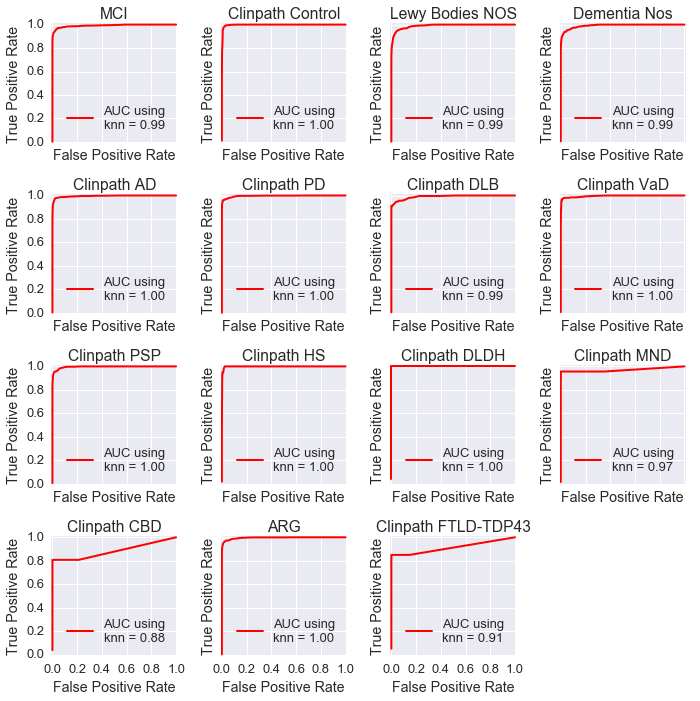

In [10]:
# Plot ROC curves for each model.  
sns.set(font_scale=1.3)
s.plot_just_rocs(Y_clean,ps,ys,imps)

In [11]:
# Correlations between predictions and observations for the holdout data:
diagnoses = list(Y_clean)
s.report(rs,diagnoses,imps)

knn,MCI: 0.823 +/- 0.011
knn,Clinpath Control: 0.957 +/- 0.005
knn,Lewy Bodies NOS: 0.742 +/- 0.011
knn,Dementia Nos: 0.847 +/- 0.014
knn,Clinpath AD: 0.940 +/- 0.006
knn,Clinpath PD: 0.953 +/- 0.006
knn,Clinpath DLB: 0.790 +/- 0.018
knn,Clinpath VaD: 0.821 +/- 0.022
knn,Clinpath PSP: 0.841 +/- 0.018
knn,Clinpath HS: 0.712 +/- 0.038
knn,Clinpath DLDH: 1.000 +/- 0.000
knn,Clinpath MND: 0.843 +/- 0.029
knn,Clinpath CBD: 0.946 +/- 0.023
knn,ARG: 0.910 +/- 0.007
knn,Clinpath FTLD-TDP43: nan +/- nan


/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [12]:
# Feature importances, ranked by number and location of appearances in the ensemble of decision trees
s.display_importances(X_clean,Y_clean,feature_importances,style='font-size:50%; line-height:140%')

,MCI,Control,Lewy Bodies NOS,Dementia NOS,AD,PD,DLB,VaD,PSP,HS,DLDH,MND,CBD,ARG,FTLD-TDP43
1,last bmi score,last mmse test score,last mmse test score,dementia,last mmse test score,hours since last pd,last mmse test score,last updrs interval,test_age,test_age,last bmi score,last bmi score,pmi,stint,deathage
2,last mmse test score,last updrs motor sco,medical records late,deathage,updrs i intellectual,last updrs motor sco,parkinsonism dx,stint,deathage,pd symptoms postural,bmi mean score,bmi mean score,bmi first to last in,last bmi interval be,updrs iii hand movem
3,medical records late,parkinsonism dx,last updrs motor sco,test_age,stint,pd symptoms response,last updrs interval,last bmi interval be,stint,deathage,expired age,bmi first to last in,last mmse interval b,bmi first to last in,smell_22d
4,bmi mean score,upsit_total,medical records earl,expired age,last updrs interval,pd certainty percent,last bmi interval be,pmi,medical records tota,last mmse test score,parkinsonism dx,updrs iii leg agilit,deathage,pmi,smell_8c
5,pmi,updrs i intellectual,last mmse interval b,updrs ii freezing wh,smell_30d,parkinsonism dx,medical records tota,last mmse interval b,expired age,pd symptoms bradykin,updrs iii rigidity l,smell_34d,smell_33a,last updrs interval,smell_20b
6,stint,updrs iii body brady,stint,bmi mean score,last bmi interval be,updrs iii body brady,stint,medical records tota,bmi mean score,medical records tota,deathage,smell_32d,timed tapping score,deathage,last updrs interval
7,medical records earl,modified hoehn and y,bmi mean score,last bmi score,bmi mean score,modified hoehn and y,smell_8d,medical records earl,bmi first to last in,pd symptoms persiste,upsit_total,upsit_total,medical records tota,last bmi score,updrs iii hand movem
8,medical records tota,stint,medical records tota,medical records earl,pmi,pd symptoms motor fl,smell_28d,deathage,upsit_total,pd symptoms asymmetr,test_age,deathage,last updrs interval,bmi mean score,pd symptoms bradykin
9,upsit_total,test_age,last bmi score,medical records tota,upsit_total,upsit_total,smell_30a,bmi first to last in,smell_2a,medical records earl,updrs ii falling on,smell_19c,test_age,test_age,test_age
10,test_age,updrs iii finger tap,education years,stint,bmi first to last in,updrs iii speech off,smell_40b,test_age,medical records earl,upsit_total,smell_39a,updrs iii leg agilit,medical records late,medical records tota,smell_reduced_or_abs


## Fit the model without smell information and display results

In [13]:
# Re-run, using no smell information for prediction.
rs,feature_importances,ys,ps = s.fit_models(imps,X_nosmell,Y,Y_clean,n_estimators=100,n_splits=25)

Fitting model for MCI...
Fitting model for Clinpath Control...
Fitting model for Lewy Bodies NOS...
Fitting model for Dementia Nos...
Fitting model for Clinpath AD...
Fitting model for Clinpath PD...
Fitting model for Clinpath DLB...
Fitting model for Clinpath VaD...
Fitting model for Clinpath PSP...
Fitting model for Clinpath HS...
Fitting model for Clinpath DLDH...
Fitting model for Clinpath MND...
Fitting model for Clinpath CBD...
Fitting model for ARG...
Fitting model for Clinpath FTLD-TDP43...


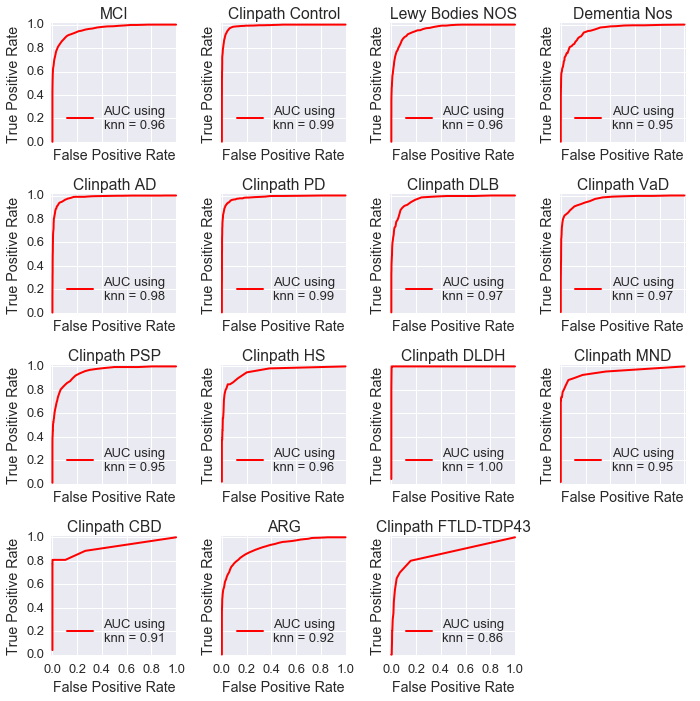

In [14]:
# Plot ROC curves for each model.  
s.plot_just_rocs(Y_clean,ps,ys,imps)

## Fit the full model without clinical PD information and display results

In [15]:
# Re-run, using no PD diagnosis information for prediction.
rs,feature_importances,ys,ps = s.fit_models(imps,X_nopark,Y,Y_clean,n_estimators=100,n_splits=25)

Fitting model for MCI...
Fitting model for Clinpath Control...
Fitting model for Lewy Bodies NOS...
Fitting model for Dementia Nos...
Fitting model for Clinpath AD...
Fitting model for Clinpath PD...
Fitting model for Clinpath DLB...
Fitting model for Clinpath VaD...
Fitting model for Clinpath PSP...
Fitting model for Clinpath HS...
Fitting model for Clinpath DLDH...
Fitting model for Clinpath MND...
Fitting model for Clinpath CBD...
Fitting model for ARG...
Fitting model for Clinpath FTLD-TDP43...


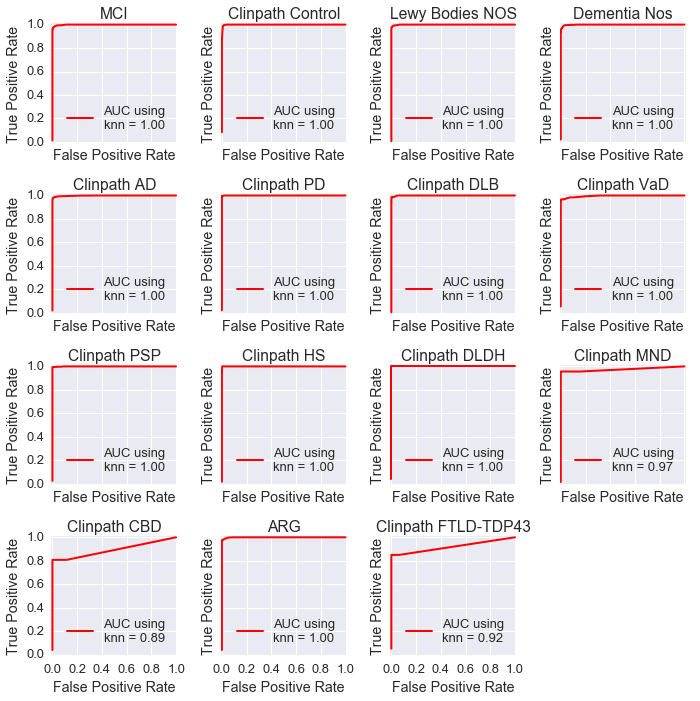

In [16]:
# Plot ROC curves for each model.  
s.plot_just_rocs(Y_clean,ps,ys,imps)

In [17]:
# Feature importances, ranked by number and location of appearances in the ensemble of decision trees
s.display_importances(X_clean_nopark,Y_clean,feature_importances,style='font-size:60%; line-height:140%')

,MCI,Control,Lewy Bodies NOS,Dementia NOS,AD,PD,DLB,VaD,PSP,HS,DLDH,MND,CBD,ARG,FTLD-TDP43
1,last mmse test score,last mmse test score,last mmse test score,dementia,last mmse test score,modified hoehn and y,last mmse test score,deathage,test_age,test_age,last bmi score,bmi mean score,pmi,stint,smell_8c
2,bmi mean score,upsit_total,medical records late,deathage,stint,dementia,smell_8d,last mmse interval b,deathage,deathage,bmi mean score,last bmi score,bmi first to last in,bmi first to last in,smell_16a
3,last bmi score,modified hoehn and y,stint,test_age,last bmi interval be,test_age,last bmi interval be,last bmi interval be,stint,last mmse test score,test_age,bmi first to last in,smell_33a,last bmi interval be,deathage
4,medical records late,test_age,last mmse interval b,bmi mean score,bmi mean score,deathage,medical records tota,stint,medical records tota,medical records tota,smell_39a,upsit_total,timed tapping score,pmi,test_age
5,pmi,stint,medical records tota,expired age,last mmse interval b,upsit_total,stint,pmi,upsit_total,stint,upsit_total,smell_34d,test_age,deathage,smell_15d
6,stint,dementia,test_age,last bmi score,upsit_total,expired age,smell_2a,medical records tota,last mmse interval b,pmi,deathage,smell_32d,smell_32d,bmi mean score,smell_5b
7,medical records earl,deathage,medical records earl,medical records tota,medical records tota,smell_24a,smell_40b,medical records earl,bmi first to last in,medical records earl,expired age,smell_9a,smell_29c,last bmi score,stint
8,medical records tota,timed tapping score,bmi first to last in,stint,deathage,smell_19b,movement exam id,test_age,bmi mean score,movement exam id,smell_4c,deathage,deathage,test_age,smell_11d
9,test_age,last bmi interval be,deathage,medical records earl,pmi,last mmse test score,bmi first to last in,bmi first to last in,dementia,bmi first to last in,medical records earl,smell_19c,last mmse interval b,last mmse interval b,smell_25b
10,upsit_total,smell_24a,last bmi score,modified hoehn and y,bmi first to last in,smell_16d,upsit_total,last bmi score,expired age,postmortem global cd,purdue pegboard scor,smell_19b,purdue pegboard scor,medical records tota,last bmi interval be
